# **Preparing the Data**

In [17]:
# get Reddit data from convokit, see more detials about the packages here: https://convokit.cornell.edu/documentation/tutorial.html
# https://convokit.cornell.edu/documentation/subreddit.html
# Data is from 2012 to 2018.

!pip3 install convokit
from convokit import Corpus, download
import pandas as pd
corpus = Corpus(filename=download("subreddit-gradadmissions"))

Dataset already exists at /Users/utkarsh/.convokit/downloads/subreddit-gradadmissions


In [18]:
corpus.print_summary_stats()

Number of Speakers: 15190
Number of Utterances: 101971
Number of Conversations: 18266


In [ ]:
'''
Utterance-level information
Each individual post or comment is viewed as an utterance. For each utterance, we provide:

id: index of the utterance
speaker: the speaker who authored the utterance
conversation_id: id of the first utterance in the conversation this utterance belongs to
reply_to: id of the utterance to which this utterance replies to (None if the utterance is not a reply)
timestamp: time of the utterance
text: textual content of the utterance
-----------------------------------------------

Metadata for each utterance may include:

score: score (i.e., the number of upvotes minus the number of downvotes) of the content
top_level_comment: the id of the top level comment (None if the utterance is a post)
retrieved_on: unix timestamp of the time of when the data is retrieved
gilded: gilded status of the content
gildings: gilding information of the content
stickied: stickied status of the content
permalink: permanent link of the content
author_flair_text: flair of the author
-----------------------------------------------

Conversational-level information
Each post with its corresponding comments are considered a conversation. For each conversation, we provide:

title: title of the post
num_comments: number of comments following this post
domain: domain of the post
subreddit: subreddit this post is retrieved from
gilded: gilded status of the post
gildings: gilding information of the post
stickied: stickied status of the post
author_flair_text: flair of the author
'''

In [19]:
# Filter the data and only get posts & replies regarding rejection when the words are in the title.
keywords = ['rej', 'reject', 'rejection', 'rejections', 'rejected', 'Rejected'] # Add more if there is anything missing

filtered_conversations = []
for convo_id in corpus.conversations:
    post = corpus.get_conversation(convo_id)
    title = post.meta['title']
    utterances = [post.get_utterance(utt_id) for utt_id in post.get_utterance_ids()]
    replies = [utt for utt in utterances if utt.reply_to is not None]
    if any(keyword.lower() in title.lower() for keyword in keywords):
      for reply in replies:
        filtered_conversations.append({
            'title': title,
            'conversation_id': post.id,
            'reply_id': reply.id,
            'reply_to': reply.reply_to,
            'speaker': reply.speaker if reply.speaker else None,
            'text': reply.text,
            'timestamp': reply.timestamp,
            'word_count': len(reply.text.split())
        })
df_replies = pd.DataFrame(filtered_conversations)

# To remove rows where 'text' column is exactly '[deleted]'
df_replies = df_replies[df_replies['text'] != '[deleted]']

# Or, to remove rows where 'text' contains '[deleted]' anywhere in the text
df_replies.drop(df_replies[df_replies['text'].str.contains('\[deleted\]', regex=True)].index, inplace=True)

# To remove rows where 'word_count' column is 0
df_replies = df_replies[df_replies['word_count'] > 0]

In [ ]:
df_replies.head(5)

title conversation_id reply_id  \
0  Put on waiting list for admission to a German ...          4w94pd  d65os5q   
1  Put on waiting list for admission to a German ...          4w94pd  d66qlxw   
2  Rejected PhD app referred to UChicago MAPSS-- ...           qirmv  c3xx3hr   
3  Rejected PhD app referred to UChicago MAPSS-- ...           qirmv  c3xxjak   
5  Rejected PhD app referred to UChicago MAPSS-- ...           qirmv  c3ya80n   

  reply_to                                            speaker  \
0   4w94pd  Speaker(id: 'Impune', vectors: [], meta: Convo...   
1  d65os5q  Speaker(id: 'nearedge', vectors: [], meta: Con...   
2    qirmv  Speaker(id: 'feralparakeet', vectors: [], meta...   
3    qirmv  Speaker(id: 'thisiscirclejerkrite', vectors: [...   
5    qirmv  Speaker(id: '[deleted]', vectors: [], meta: Co...   

                                                text   timestamp  word_count  
0  What's the benefit of withdrawing your applica...  1470421397           7  
1  I don't really know, that's why i asked it her...  1470497729          22  
2  I don't have any experience with that area in ...  1330968703          61  
3                         It is what you make of it.  1330970972           7  
5  You can PM me as well if you like. I was in th...  1331058605          74

# **Histogram: Length of word -> use "df_replies[word_count]"**

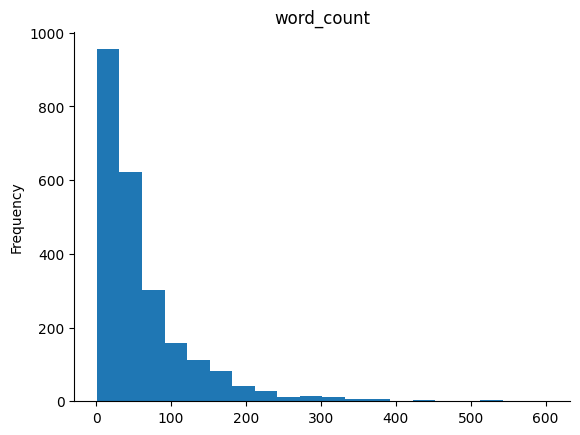

In [ ]:
# @title word_count

from matplotlib import pyplot as plt
df_replies['word_count'].plot(kind='hist', bins=20, title='word_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
len(df_replies)

2360

# **Word cloud: including 1 and 2 and 3 words as a unit**

In [ ]:
"""
Steps for word cloud:

Tokenizing the text to break it down into individual words.
Filtering out stop words, as these common words (like "the", "is", etc.) are usually not meaningful for word clouds.
Generating Bigrams and Trigrams from the filtered text.
Counting the frequency of each bigram and trigram across all replies to identify the most common combinations.
"""

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
from nltk import bigrams, trigrams, word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK resources if not already installed
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Initialize stop words, lemmatizer, and manually excluded words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
manual_exclusions = {}  # Add any specific words you want to exclude

# Update stop words with manual exclusions
stop_words.update(manual_exclusions)

# Function to clean text, remove stop words, and lemmatize
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lower case
    filtered_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w.isalpha()]
    return filtered_tokens

# Function to generate n-grams
def generate_ngrams(tokens, n=2):
    if n == 1:
        return tokens  # Return tokens directly for unigrams
    elif n == 2:
        return [' '.join(gram) for gram in bigrams(tokens)]
    elif n == 3:
        return [' '.join(gram) for gram in trigrams(tokens)]

# Initialize counters for unigrams, bigrams, and trigrams
unigram_counter = Counter()
bigram_counter = Counter()
trigram_counter = Counter()

# Process each reply in the dataset
for conversation in filtered_conversations:
    text = conversation['text']
    tokens = preprocess_text(text)
    unigram_counter.update(generate_ngrams(tokens, n=1))  # Update unigram counter
    bigram_counter.update(generate_ngrams(tokens, n=2))
    trigram_counter.update(generate_ngrams(tokens, n=3))

# At this point:
# unigram_counter contains the frequencies of individual words
# bigram_counter contains the frequencies of bigrams
# trigram_counter contains the frequencies of trigrams

In [ ]:
"""
2. Preparing Data for Word Clouds
With the bigram_counter and trigram_counter filled with the frequencies of bigrams and trigrams,
we can easily use these counters to generate word clouds. Most word cloud libraries or
tools can take a dictionary of word frequencies as input.
"""

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [10]:
df = pd.read_csv("unigram.csv")
word_frequencies = df.set_index('ngram')['count'].to_dict()

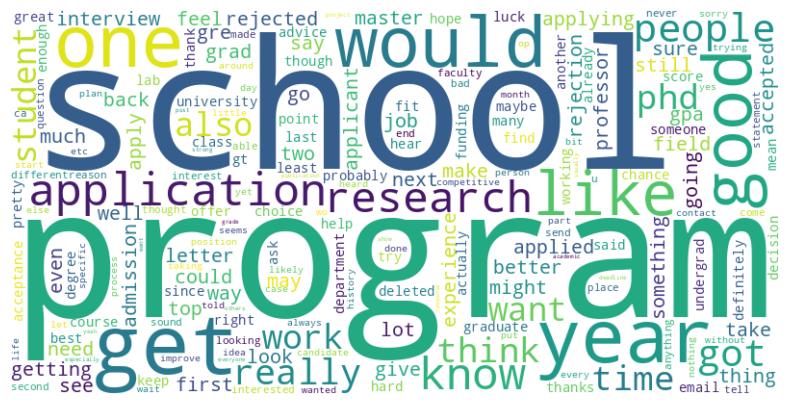

In [12]:
df = pd.read_csv("unigram.csv")
word_frequencies = df.set_index('ngram')['count'].to_dict()
unigram_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_frequencies)

# Display the unigram word cloud
plt.figure(figsize=(10, 5))
plt.imshow(unigram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

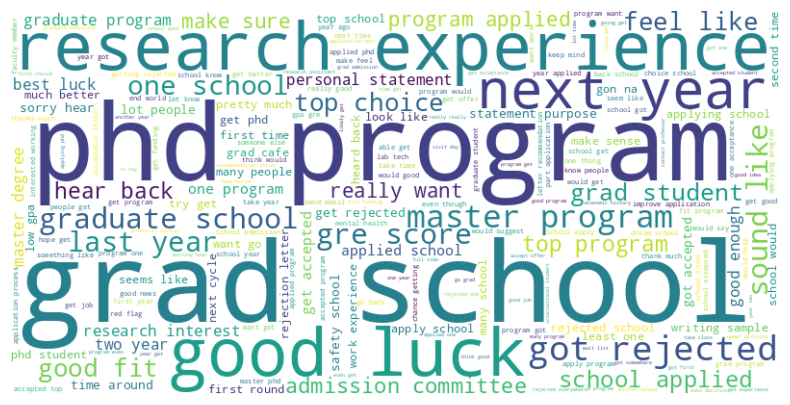

In [ ]:
# Generate a word cloud for bigram
bigram_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(bigram_counter)

# Display the bigram word cloud
plt.figure(figsize=(10, 5))
plt.imshow(bigram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

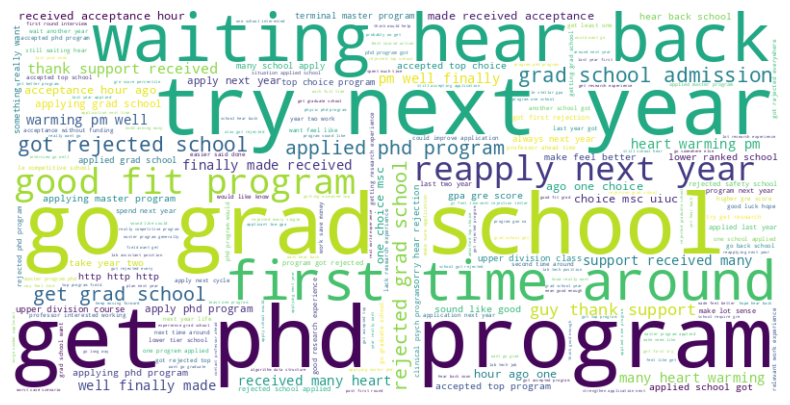

In [ ]:
# Generate a word cloud for trigram
trigram_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(trigram_counter)

# Display the trigram word cloud
plt.figure(figsize=(10, 5))
plt.imshow(trigram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# **Bubble chart (interactive)**



In [ ]:
'''
Step 1: Review a Subset of Responses and Identify Keywords
We should manually review a subset of responses to identify keywords and phrases related to our categories.
This step requires our input as it's subjective and based on understanding the context.
'''
# Randomly sample a subset of responses for review
review_subset = df_replies.sample(n=25, random_state=1)

i=0
for text in review_subset['text']:
  i+=1
  print(i)
  print(text)

1
Either option is fine. I'd give your formal answer plus a little shoutout to how helpful they've been (for both schools whether you're accepting or rejection). In the end, it really really doesn't matter. It's unlikely anyone will remember the specifics of your email after a few weeks or take it very personally.
2
PhD.
3
alcohol
4
Yeah, some wait until the very end of the season to actually send rejections (i.e. late April), and others just don't tell you unless you ask.
5
No, it's not true at all. Some programs notify rejections all at once--whether you made the shortlist or not. Some programs don't even start reviewing applications until February (even though they've had them since December).

You can try to ask what you can do to improve chances of admission, but likely they'll give you a vague response. Good luck.
6
Not necessarily. That's about the best anyone can say.
7
The issue was that a) did my undergrad in Math. Hated it. b) My father passed away a couple of months before 

In [ ]:
# After manually coding the replies

# Example keywords for each category
keywords = {
    'Emotional Support': ['sorry', 'feel', 'empathy', 'understand', "life", "learn", "forward", "work out", "relieving"],
    'Informational Support': ['info', 'information', 'advice', 'guide', "fund", "research", "research experience", "fit", "match", "sop",
                              "background", "email","recommendation", "GPA", "interview", "feedback",],
    'Encouragement': ['keep going', "don't give up", 'believe', 'you can', "survive", "hard on yourself", "hope", "good luck"],
    "Personal Experience":["my experience", "my"],
    "Sensitive Topics":["mental health", "mental", 'alcohol', 'die', 'drug', 'harm', "self harm", 'medication', 'meds',
                        "anxiety", "stress", "stressful", "suicide", "suicidal"]}

# Function to categorize responses based on keywords
def categorize_response(text):
    category = 'Other'  # Default category if no keywords match
    for cat, keys in keywords.items():
        if any(key in text.lower() for key in keys):
            return cat
    return category

In [ ]:
#testing on a small subset to see the categories

# Apply categorization to a small subset for testing
test_subset = df_replies.head(50)  # Adjust as needed for testing
test_subset['category'] = test_subset['text'].apply(categorize_response)

# Print the DataFrame showing full text and category
print(test_subset[['text', 'category']])

                                                 text               category
0   What's the benefit of withdrawing your applica...  Informational Support
1   I don't really know, that's why i asked it her...    Personal Experience
2   I don't have any experience with that area in ...                  Other
3                          It is what you make of it.                  Other
5   You can PM me as well if you like. I was in th...  Informational Support
7   I believe there are outright rejections... My ...          Encouragement
9   I'm not sure if there is such a time. \n\nJust...                  Other
10  What would they say if they had the budget to ...  Informational Support
11  Although I can empathize with you, ultimately ...      Emotional Support
12  You only applied to extremely well-ranked prog...  Informational Support
13  If you're international then it has nothing to...  Informational Support
14  I think you just aimed way too high considerin...          Encouragement

<ipython-input-70-f61eb6fe83ef>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# actually categorizing the dataset

# Apply categorization to the entire dataset
df_replies['category'] = df_replies['text'].apply(categorize_response)

# Review the distribution of categories
print(df_replies['category'].value_counts())

Other                    828
Informational Support    700
Emotional Support        430
Personal Experience      213
Encouragement            165
Sensitive Topics          24
Name: category, dtype: int64


### **In our bubble chart:**

**Color represents** the type of information the responses provide.

**Size** indicates how many times a word is mentioned in the community.

**Grouped by Themes** means that words are clustered based on related themes.

In [ ]:
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words
stop_words_set = set(stopwords.words('english'))
stop_words_set.update({"n't", "get", "like", "one", "would", "school", "program", "programs", "schools", "got", "'ve", "'re"})

# Initialize a dictionary to hold word frequencies within each category
word_frequencies_by_category = {category: Counter() for category in df_replies['category'].unique()}

for category in word_frequencies_by_category.keys():
    # Filter the replies by category
    filtered_replies = df_replies[df_replies['category'] == category]['text']

    # Tokenize and count words in each category
    for reply in filtered_replies:
        # Tokenize and convert to lower case
        tokens = word_tokenize(reply.lower())
        # Remove stopwords and words with less than 3 characters
        tokens = [token for token in tokens if token not in stop_words_set and len(token) > 2]
        # Update the counter for the category
        word_frequencies_by_category[category].update(tokens)

# Example: print word frequencies for the 'Emotional Support' category
print(word_frequencies_by_category['Emotional Support'].most_common(10))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('good', 172), ('feel', 165), ('research', 151), ('really', 144), ('year', 144), ('know', 135), ('people', 129), ('work', 128), ('think', 127), ('time', 127)]


In [ ]:
import pandas as pd

# Aggregating word frequencies and categories for visualization
words_data = []
for category, counter in word_frequencies_by_category.items():
    for word, freq in counter.items():
        words_data.append({'word': word, 'frequency': freq, 'category': category})

# Convert to DataFrame
df_words = pd.DataFrame(words_data)

In [ ]:
import numpy as np
import pandas as pd

# Convert 'category' column to categorical type if it's not already
df_words['category'] = df_words['category'].astype('category')

# Now you can use .cat.codes
df_words['jittered_x'] = np.random.uniform(-0.3, 0.3, size=len(df_words)) + df_words['category'].cat.codes

# Then you can plot using the jittered_x for the x-axis value to spread out the points horizontally

import plotly.express as px

fig = px.scatter(df_words,
                 x='jittered_x',
                 y='frequency',
                 size='frequency',
                 color='category',
                 hover_name='word',
                 title='Word Frequencies by Support Category')

# Hide the original x-axis labels and ticks since they are just jitter values
fig.update_xaxes(title_text='', showticklabels=False)

# Update y-axis title
fig.update_yaxes(title_text='Word Frequency')

# Show the figure
fig.show()


---

# **LDA topic modeling**

In [ ]:
# Topic Modeling, the code refers to a tutorial about LDA topic modeling here: https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/
!pip3 install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words=set(nltk.corpus.stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def clean_text(headline):
    '''
    Lemmatization is the process of converting a word into its base or dictionary form.
    For example, "running" becomes "run".
    '''
    le = WordNetLemmatizer()
    word_tokens = word_tokenize(headline)
    '''
    This line filters out stopwords (common words that are usually removed in NLP tasks because they carry little useful information, like "and", "the", etc.)
    and words shorter than 4 characters. It also converts all words to lowercase and lemmatizes them. The result is a list of processed tokens.
    '''
    tokens = [le.lemmatize(w).lower() for w in word_tokens if w.lower() not in stop_words and len(w) > 2] # including "sad", "mad", etc
    cleaned_text = " ".join(tokens)
    return cleaned_text

df_replies['cleaned_text']=df_replies['text'].apply(clean_text)

'''
TF-IDF is a statistical measure used to evaluate the importance of a word to a document in a collection of documents.
'''
vect = TfidfVectorizer(stop_words=list(stop_words), max_features=1000)
vect_text = vect.fit_transform(df_replies['cleaned_text'])

In [ ]:
"""
Choosing the right number of topics using models' log-likelihood for evaluating model quality.
"""
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Assuming df_replies['cleaned_text'] contains your preprocessed text
count_vect = CountVectorizer(stop_words=list(stop_words), max_features=1000)
doc_term_matrix = count_vect.fit_transform(df_replies['cleaned_text'])

results = []
topic_numbers = range(2, 11)  # Exploring from 2 to 10 topics

for n_topics in topic_numbers:
    lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=42, max_iter=10)
    lda_model.fit(doc_term_matrix)

    log_likelihood = lda_model.score(doc_term_matrix)
    results.append((n_topics, log_likelihood))

# Selecting the number of topics with the highest log likelihood
best_topic_num, best_log_likelihood = max(results, key=lambda x: x[1])

print(f"Optimal number of topics: {best_topic_num}, with Log Likelihood: {best_log_likelihood}")

# Fit the optimal model
lda_optimal_model = LatentDirichletAllocation(n_components=best_topic_num, learning_method='online', random_state=42, max_iter=10)
lda_top_optimal = lda_optimal_model.fit_transform(doc_term_matrix)

# Example: Displaying topic distribution for Document 0 in the optimal model
print("Reddit Replies: ")
for i, topic in enumerate(lda_top_optimal[0]):
    print("Topic", i, ":", topic * 100, "%")

Optimal number of topics: 2, with Log Likelihood: -351418.03613757575
Reddit Replies: 
Topic 0 : 27.687715843869338 %
Topic 1 : 72.31228415613066 %


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=3, # the number of topics is chosen as 3
learning_method='online',random_state=42,max_iter=1)
lda_top=lda_model.fit_transform(vect_text)

print("Reddit Replies: ")
for i,topic in enumerate(lda_top[0]):
    print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  17.841269453933833 %
Topic  1 :  19.864317455368884 %
Topic  2 :  62.294413090697276 %


In [ ]:
vocab = vect.get_feature_names_out()
for i, comp in enumerate(lda_model.components_):
     vocab_comp = zip(vocab, comp)
     sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:5]
     print("Topic "+str(i)+": ")
     for t in sorted_words:
        print(t[0],end=" ")
     print("\n")

Topic 0: 
interview email ask program heard 

Topic 1: 
thanks hope give help use 

Topic 2: 
deleted thank deadline lol 1st 

Topic 3: 
gpa score gre applicant class 

Topic 4: 
phd program master funding degree 

Topic 5: 
program research experience field work 

Topic 6: 
school year get one program 

Topic 7: 
like time get already something 

Topic 8: 
send acceptance email http rejection 

Topic 9: 
good know get got rejection 



In [1]:
import pandas as pd

In [13]:
df_unigram = pd.read_csv("bigram.csv")
unigram_word_frequencies = df_unigram.set_index('ngram')['count'].to_dict()
print(unigram_word_frequencies)

{'benefit withdrawing': 1, 'withdrawing application': 1, 'really know': 6, 'know asked': 1, 'asked guess': 1, 'guess one': 2, 'one would': 3, 'would get': 16, 'get spot': 2, 'experience area': 2, 'area particular': 1, 'particular social': 1, 'social scientist': 1, 'scientist would': 1, 'would done': 3, 'done anything': 3, 'anything chance': 1, 'chance study': 1, 'study chicago': 1, 'chicago would': 1, 'would anything': 1, 'anything cost': 1, 'cost stopping': 1, 'stopping moving': 2, 'moving phd': 2, 'phd later': 2, 'later know': 1, 'know sociology': 1, 'sociology social': 1, 'social science': 6, 'science normal': 1, 'normal step': 1, 'pm well': 9, 'well like': 1, 'like maph': 1, 'maph program': 2, 'program humanity': 1, 'humanity sibling': 1, 'sibling map': 1, 'map shifted': 1, 'shifted gear': 1, 'gear since': 1, 'since accepted': 1, 'accepted higher': 1, 'higher education': 3, 'education policy': 1, 'policy program': 3, 'program dream': 1, 'dream map': 1, 'map maph': 1, 'program certa

In [14]:
unigram_wordcloud = WordCloud(width=600, height=300, background_color='white').generate_from_frequencies(unigram_word_frequencies)

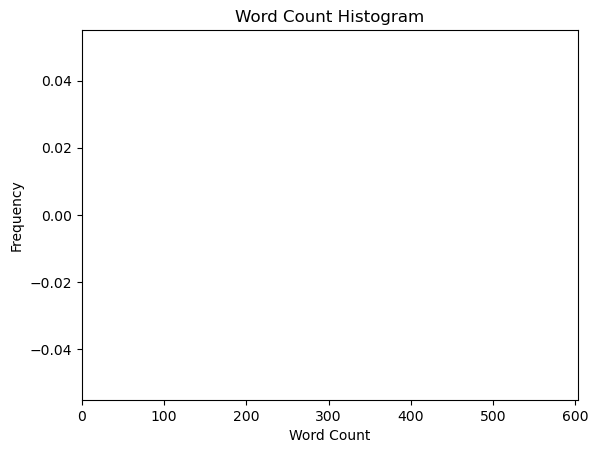

In [20]:
# @title word_count

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# df_replies['word_count'].plot(kind='hist', bins=20, title='word_count')
# plt.gca().spines[['top', 'right',]].set_visible(False)
data = df_replies['word_count'].values

# Setup the figure and axes...
fig, ax = plt.subplots()
ax.set_title('Word Count Histogram')
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')

# Initial histogram: empty or a single data point
hist, bins, _ = plt.hist(data, bins=20, alpha=0.75, color='blue')

# Adjust the animation to update every Nth frame for quicker updates
N = 20  # Adjust N to control the speed and smoothness

def animate(i):
    current_index = i * N
    ax.cla()  # Clear the axis
    if current_index < len(data):
        ax.hist(data[:current_index], bins=20, alpha=0.75, color='blue')
    else:
        ax.hist(data, bins=20, alpha=0.75, color='blue')
    ax.set_title('Word Count Histogram')
    ax.set_xlabel('Word Count')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, max(data))   
frames = range(0, (len(data) // N) + 1)

# Create the animation with the adjusted frame rate
anim = FuncAnimation(fig, animate, frames=frames, interval=100)

# Display the animation
HTML(anim.to_jshtml())
